In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.0.0


# Arbitrary Waveform

In addition to the frequently employed waveforms, [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) boasts the capability to simulate arbitrary waveforms. This versatility allows you to precisely define waveforms by specifying their frequency versus time curves. In the subsequent illustration, we will harness the potential of arbitrary waveform simulation to assess the impact of a non-linear chirp within the context of an FMCW radar scenario.

## Introduction

The chirp linearity in an FMCW radar pertains to the degree of adherence of the actual frequency modulation to the intended linear frequency sweep. In the realm of FMCW radar, a continuous waveform characterized by a linearly ascending or descending frequency, known as a chirp signal, is propagated. This chirp signal serves the purpose of gauging the distance to a target by leveraging the time delay between the emission and reception of signals.

The significance of chirp linearity lies in its role as a pivotal attribute. Even slight deviations from the anticipated linear frequency progression can usher in inaccuracies during range measurement and velocity estimation. In situations where the chirp doesn't impeccably adhere to linearity, the radar system runs the risk of miscalculating the target's distance and velocity. The ramifications of such discrepancies extend to compromised precision in target identification, tracking, and spatial localization.

Illustrating the concept, the subsequent code examples will elucidate the creation of a non-linear chirp within RadarSimPy. Through this, we aim to assess the ensuing impact on the radar signal processing workflow.

## Create Radar Models

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Non-linear Chirp vs. Linear Chirp

The non-linear chirp can be defined by frequency versus time. This curve can be measured directly from an FMCW radar frequency synthesizer through a signal and spectrum analyzer. For example, Rohde & Schwarz FSW Signal and spectrum analyzer, or Keysight's UXA Signal Analyzer is capable of measuring the chirp directly.


In [3]:
freq_nonlinear = np.array(
    [
        2.40750000e10,
        2.40760901e10,
        2.40771786e10,
        2.40782654e10,
        2.40793506e10,
        2.40804341e10,
        2.40815161e10,
        2.40825964e10,
        2.40836750e10,
        2.40847521e10,
        2.40858275e10,
        2.40869012e10,
        2.40879734e10,
        2.40890439e10,
        2.40901127e10,
        2.40911800e10,
        2.40922456e10,
        2.40933096e10,
        2.40943719e10,
        2.40954326e10,
        2.40964917e10,
        2.40975491e10,
        2.40986049e10,
        2.40996591e10,
        2.41007117e10,
        2.41017626e10,
        2.41028119e10,
        2.41038595e10,
        2.41049055e10,
        2.41059499e10,
        2.41069927e10,
        2.41080338e10,
        2.41090733e10,
        2.41101111e10,
        2.41111473e10,
        2.41121819e10,
        2.41132149e10,
        2.41142462e10,
        2.41152759e10,
        2.41163039e10,
        2.41173304e10,
        2.41183552e10,
        2.41193783e10,
        2.41203999e10,
        2.41214198e10,
        2.41224380e10,
        2.41234546e10,
        2.41244696e10,
        2.41254830e10,
        2.41264947e10,
        2.41275048e10,
        2.41285133e10,
        2.41295202e10,
        2.41305254e10,
        2.41315289e10,
        2.41325309e10,
        2.41335312e10,
        2.41345298e10,
        2.41355269e10,
        2.41365223e10,
        2.41375161e10,
        2.41385082e10,
        2.41394987e10,
        2.41404876e10,
        2.41414748e10,
        2.41424605e10,
        2.41434444e10,
        2.41444268e10,
        2.41454075e10,
        2.41463866e10,
        2.41473640e10,
        2.41483399e10,
        2.41493140e10,
        2.41502866e10,
        2.41512575e10,
        2.41522268e10,
        2.41531945e10,
        2.41541605e10,
        2.41551249e10,
        2.41560876e10,
        2.41570488e10,
        2.41580083e10,
        2.41589661e10,
        2.41599224e10,
        2.41608770e10,
        2.41618299e10,
        2.41627812e10,
        2.41637309e10,
        2.41646790e10,
        2.41656254e10,
        2.41665702e10,
        2.41675134e10,
        2.41684550e10,
        2.41693949e10,
        2.41703331e10,
        2.41712698e10,
        2.41722048e10,
        2.41731381e10,
        2.41740699e10,
        2.41750000e10,
    ]
)
t_nonlinear = np.linspace(0, 80e-6, 100)

The linear chirp can be defined from its start frequency and end frequency.


In [4]:
freq_linear = np.array([24.125e9 - 50e6, 24.125e9 + 50e6])
t_linear = np.array([0, 80e-6])

_Plot the non-linear chirp and the linear chirp_


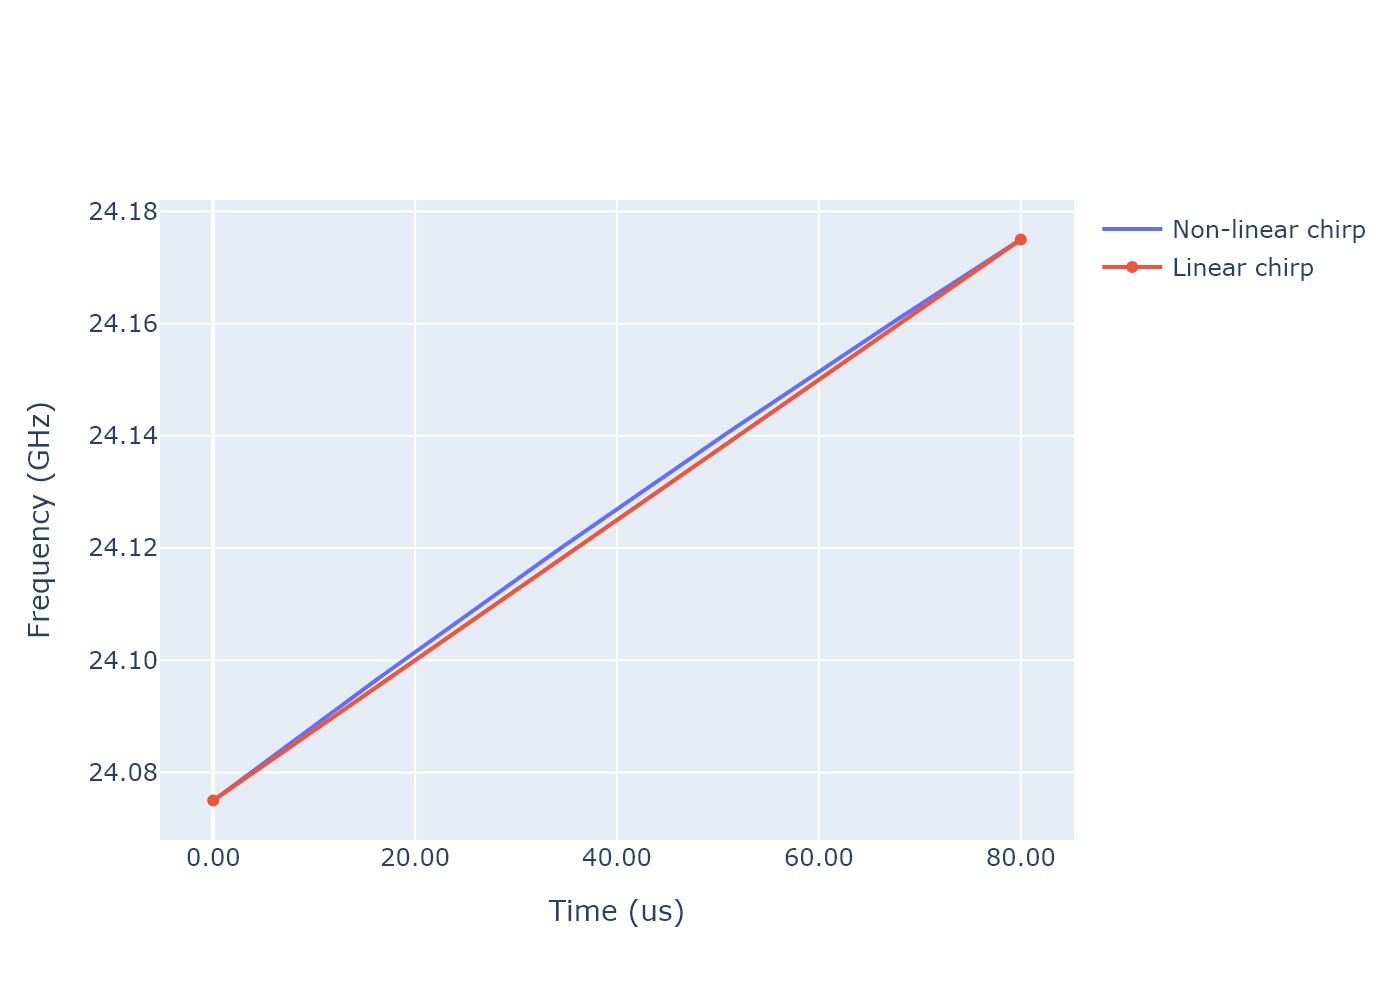

In [5]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=t_nonlinear * 1e6,
        y=freq_nonlinear / 1e9,
        name="Non-linear chirp",
    )
)
fig.add_trace(
    go.Scatter(
        x=t_linear * 1e6,
        y=freq_linear / 1e9,
        name="Linear chirp",
    )
)
fig.update_layout(
    yaxis=dict(tickformat=".2f", title="Frequency (GHz)"),
    xaxis=dict(tickformat=".2f", title="Time (us)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Transmitters

Here we created 2 transmitters, one with the linear chirp and the other is with the non-linear chirp.


In [6]:
tx_nonlinear = Transmitter(
    f=freq_nonlinear,
    t=t_nonlinear,
    tx_power=60,
    prp=100e-6,
    pulses=1,
    channels=[
        dict(
            location=(0, 0, 0),
        )
    ],
)

tx_linear = Transmitter(
    f=freq_linear,
    t=t_linear,
    tx_power=60,
    prp=100e-6,
    pulses=1,
    channels=[
        dict(
            location=(0, 0, 0),
        )
    ],
)

### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.


In [7]:
rx = Receiver(
    fs=2e6,
    noise_figure=12,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=[
        dict(
            location=(0, 0, 0),
        )
    ],
)

### Radar Systems

Create 2 FMCW radar systems with the linear/non-linear chirp perperties.


In [8]:
radar_nonlinear = Radar(transmitter=tx_nonlinear, receiver=rx)
radar_linear = Radar(transmitter=tx_linear, receiver=rx)

### Targets

To evaluate the impact of non-linear chirp, 3 targets with different locations are defined in the simulation scenario. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (degree).


In [9]:
target_1 = dict(location=(200, 0, 0), speed=(-5, 0, 0), rcs=30, phase=0)
target_2 = dict(location=(95, 20, 0), speed=(-50, 0, 0), rcs=25, phase=0)
target_3 = dict(location=(30, -5, 0), speed=(-22, 0, 0), rcs=15, phase=0)

targets = [target_1, target_2, target_3]

## Simulate Baseband Signals

Use the `simulator.sim_radar` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [10]:
from radarsimpy.simulator import sim_radar

data_nonlinear = sim_radar(radar_nonlinear, targets)
timestamp_nonlinear = data_nonlinear["timestamp"]
baseband_nonlinear = data_nonlinear["baseband"]+data_nonlinear["noise"]

data_linear = sim_radar(radar_linear, targets)
timestamp_linear = data_linear["timestamp"]
baseband_linear = data_linear["baseband"]+data_linear["noise"]

## Radar Signal Processing

### Range profile

With an FMCW radar, the range profile of the targets could be obtained through a simple FFT across the samples of the chirp. This process is also known as the range-FFT.


In [11]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(
    radar_linear.sample_prop["samples_per_pulse"], at=60
)

range_profile_nonlinear = proc.range_fft(baseband_nonlinear[:, :, :], range_window)
range_profile_linear = proc.range_fft(baseband_linear[:, :, :], range_window)

_Plot the range profiles_


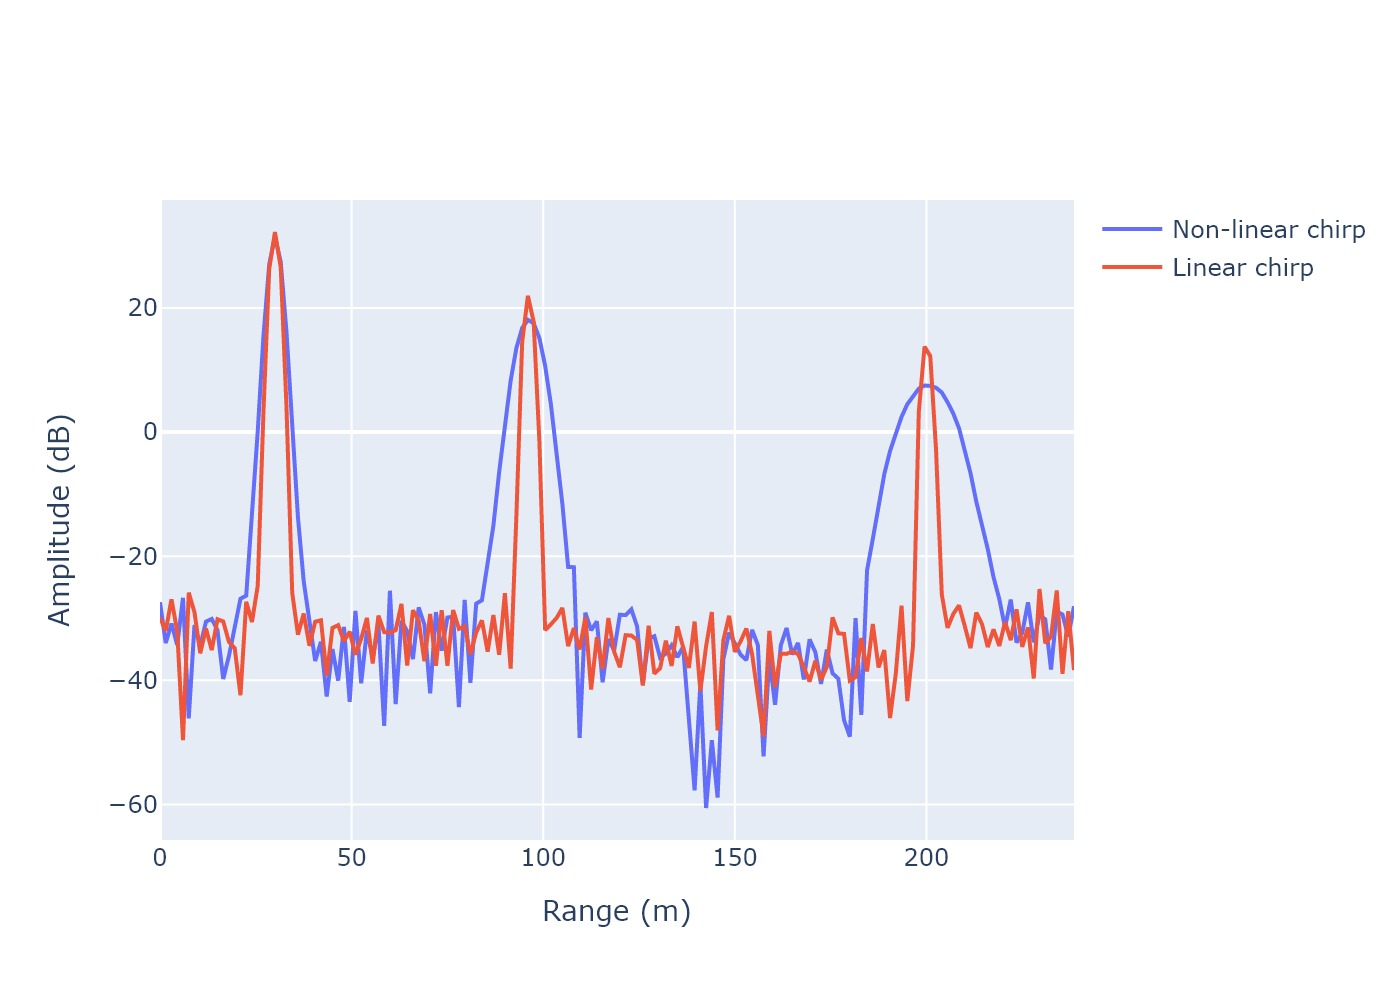

In [12]:
max_range = (
    3e8
    * radar_linear.radar_prop["receiver"].bb_prop["fs"]
    * radar_linear.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar_linear.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 2
)

range_axis = np.linspace(
    0, max_range, radar_linear.sample_prop["samples_per_pulse"], endpoint=False
)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(np.abs(range_profile_nonlinear[0, 0, :])),
        name="Non-linear chirp",
    )
)
fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(np.abs(range_profile_linear[0, 0, :])),
        name="Linear chirp",
    )
)
fig.update_layout(
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Range (m)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

The impact of non-linearity becomes readily apparent when observing the range profiles. As the range extends, the once-narrow beams of the target widen, significantly undermining both range discrimination and accuracy. Furthermore, the signal-to-noise ratio (SNR) experiences pronounced deterioration over greater distances. Consequently, ensuring optimal performance across the radar's range coverage in an FMCW radar hinges upon maintaining impeccable chirp linearity.
